In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Comparing Two Samples

First, let's read in the data

In [2]:
births = Table.read_table('baby.csv')

In [3]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


Let's look at the columns 'Maternal Smoker' (whether the mother smoked during pregnancy) and the 'Birth Weight'

In [4]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

How many people were in each group?

In [5]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


Let's visualize the distribution!

/opt/conda/lib/python3.8/site-packages/datascience/tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


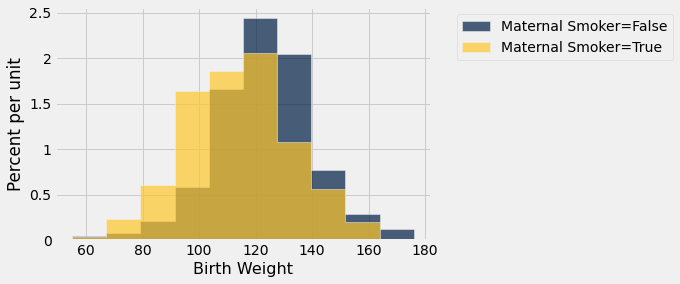

In [6]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

# Test Statistic

What's the average of each group?

In [7]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


What's the value of our test statistic?

Group B average weight - Group A average weight 

In [8]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

Write a function that takes the name of table, column label of numerical variable and column label of group-label variable, and returns the difference of means of the two groups

In [9]:
def difference_of_means(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

Use this function to generate the test statistic with any table with the two labels

In [10]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Random Permutation (Shuffling)

In [11]:
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))

In [12]:
letters.sample()

Letter
b
b
b
e
e


In [13]:
letters.sample(with_replacement = False)

Letter
b
c
e
a
d


In [14]:
letters.with_column('Shuffled', letters.sample(with_replacement = False).column(0))

Letter,Shuffled
a,a
b,b
c,d
d,c
e,e


# Simulation Under Null Hypothesis

In [15]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


Shuffle the labels of the "Maternal Smoker" column

In [16]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False
                                                ).column('Maternal Smoker')
shuffled_labels

array([False, False, False, ..., False, False,  True])

Note: we need to do .column to get the shuffled labels

Let's add the shuffled labels into our original table

In [17]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)

In [18]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,False
True,128,False
True,108,True
False,136,False
False,138,True
False,132,False
False,120,False
True,143,False
False,140,False


What's our simulated test statistic?

In [19]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

0.6106464341758482

Compare to our observed test statistic:

In [20]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Permutation Test

Write a function that returns the difference of means of the two groups after shuffling labels.

1. Get an array of shuffled labels
2. Add shuffled labels to your table
3. Calculate the test statistic for this simulation

In [21]:
def one_simulated_difference(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   

In [22]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

0.403165897283543

Let's do this 2500 times!

In [23]:
differences = make_array()

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


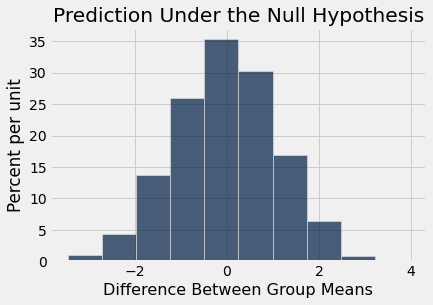

In [24]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

What's the p-value?

In [25]:
p_value = np.count_nonzero(differences <= observed_difference)/len(differences)
p_value

0.0

Compare this to a 1% p-value cutoff:

In [26]:
p_value < 0.01

True